# Telco Churn Analysis

Customer churn prediction is to measure why customers are leaving a business. In this notebook we will be looking at customer churn in telecom business.

In [1]:
#import the required libraries
import numpy as np 
import pandas as pd 
import pandas_profiling

import seaborn as sns 
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn .model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve  
from sklearn.metrics import make_scorer, fbeta_score, auc
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
# from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from collections import Counter  #for count the 1/0

import xgboost
import lightgbm
from catboost import CatBoostClassifier

In [2]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

import tensorflow as tf
from tensorflow import keras

import pickle

import warnings
warnings.filterwarnings('ignore')

## 1. Loading the Data 

The [Data Set](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?datasetId=13996&sortBy=voteCount) containing Telco customer data and showing customers left last month. 

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
#Perform Exploratory Data Analysis in just one line of code
# pandas_profiling.ProfileReport(pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv'))

In [5]:
# Summary of the dataframe
df.info(verbose = True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# find ou unique values for each column
def print_unique_col_values(df):
       for column in df:
            print(f'{column}: {df[column].unique()}') 
print_unique_col_values(df)

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


**Data Insight:**

* SeniorCitizen value is of 0/1
* 75% customers have tenure less than 55 months
* Average Monthly charges are USD 64.76 whereas 25% customers pay more than USD 89.85 per month
* TotalCharges column contains string, it should be in numerical format
* There is no missing data at the first galance
* 'Churn' Data is highly imbalanced, No/Yes ratio = 73:27, we will analyse the data with other features while taking the target values separately to get some insights.

## 2. Exploratory Data Analysis

**1. First of all, we drop the customerID since it's of no use**

In [8]:
df.drop('customerID',axis='columns',inplace=True)

**2. Total Charges should be numeric amount. Let's convert it to numerical data type**

In [9]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

As we can see there are 11 missing values in TotalCharges column. Let's check these records

In [10]:
df[np.isnan(df['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [11]:
df.iloc[488].TotalCharges

nan

**3. Remove missing value**

Since the percentage of these records with space in TotalCharges is very low ie 0.15%, it is safe to remove them 

In [12]:
# another option is fillna with mean value,  df.fillna(df["TotalCharges"].mean())

df.dropna(inplace=True)

In [13]:
df.shape

(7032, 20)

In [14]:
df["TotalCharges"].dtype

dtype('float64')

**4. Remove duplicated values**

In [15]:
df.duplicated().value_counts()

False    7010
True       22
dtype: int64

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.shape

(7010, 20)

### Explore  Numerical Columns

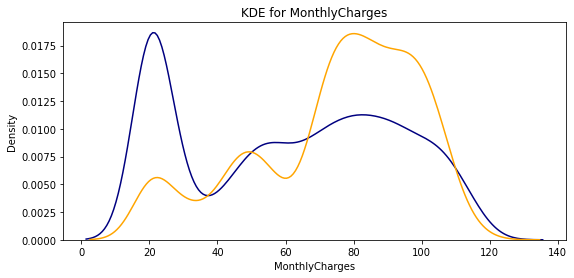

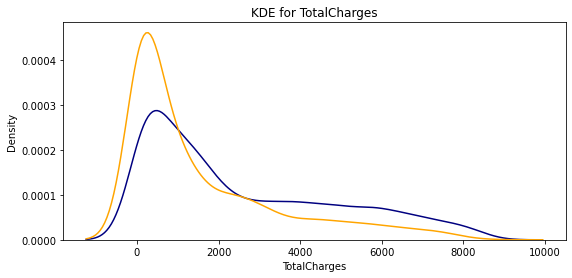

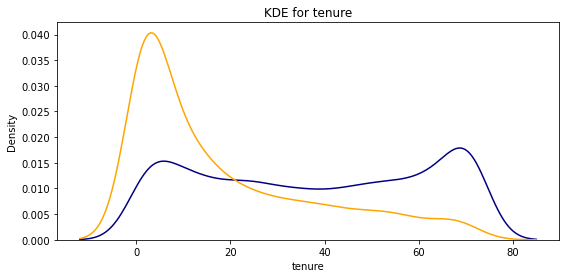

In [18]:
numerical = ["MonthlyCharges", "TotalCharges", "tenure"]

#There only three numerical columns: tenure, monthly charges and total charges.
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == "No"][feature], color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == "Yes"][feature], color= 'orange', label= 'Churn: Yes')
    
for col in numerical:
    kdeplot(col)

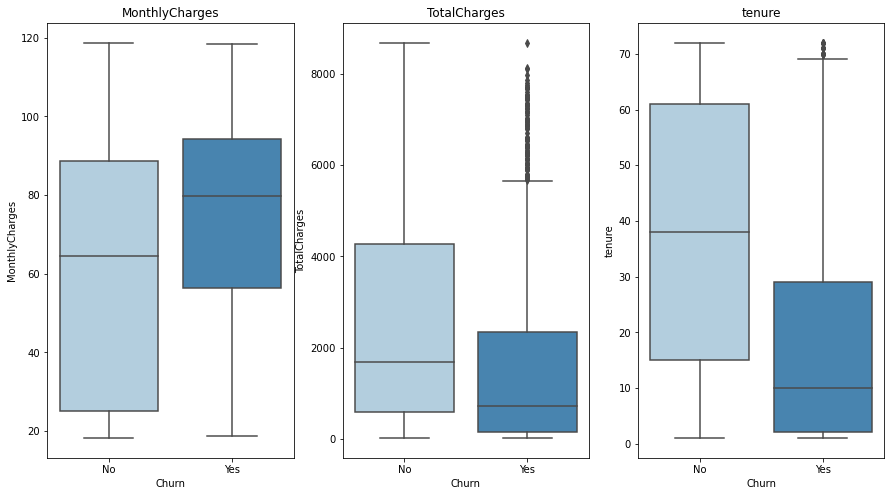

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
for variable, subplot in zip(numerical, ax.flatten()):
    sns.boxplot(x=df["Churn"], y=df[variable], ax=subplot, palette = "Blues").set_title(str(variable))


**Relationship between Monthly Charges/Total Charges/Tenure**

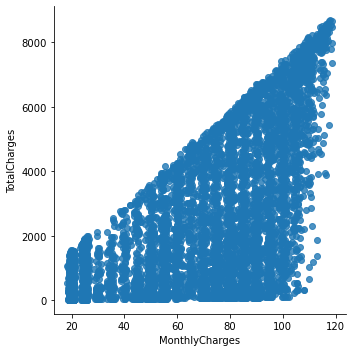

In [20]:
sns.lmplot(data=df, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

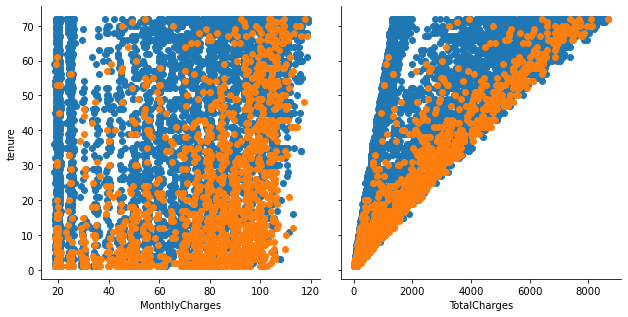

In [21]:
a=sns.PairGrid(df, y_vars=["tenure"], x_vars=["MonthlyCharges", "TotalCharges"], height=4.5, hue="Churn")
ax = a.map(plt.scatter)

In [22]:
np.corrcoef(df.TotalCharges, df.MonthlyCharges*df.tenure)

array([[1.        , 0.99955849],
       [0.99955849, 1.        ]])

**Data Insight:** 

* Churn is high when Monthly Charges at high , 
* Churn is high when Total Charges at lower , 
* Recent clients are more likely to churn.
* All the above 3 factors viz **Higher Monthly Charge**,  **Lower tenure** and **Lower Total Charge** are linkd to **High Churn**. 
* However Total Charge is determined by MonthlyCharge and tenure. we can drop the 'TotalCharges' column

**Check for Outliers in Numerical Features**

In [23]:
num_features= ['tenure', 'MonthlyCharges' ]
df_num = df[num_features]
df_num.describe()

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
IQR
((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any()

tenure            False
MonthlyCharges    False
dtype: bool

No outliers in numerical features detected with the IQR method.

### Explore Catagorical Columns:

In [ ]:
cols = 4
rows = 4

fig = plt.figure(figsize=(20,20))
sns.set(style="ticks", color_codes=True)

for i, predictor in enumerate(df.drop(columns=['Churn','tenure', 'MonthlyCharges','TotalCharges'])):
    ax=fig.add_subplot(rows,cols,i+1)
    sns.countplot(data=df, x=predictor, hue='Churn')
    
fig.tight_layout()  
plt.show()    

In [164]:
def stacked_plot(df, features, target,ax):
    df = (df.groupby([features, target]).size()/df.groupby(features)[target].count()).reset_index().pivot(columns=target, index=features, values=0)
    df.plot(kind='bar', stacked=True, ax = ax, color = ["blue", "grey"])
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xlabel(features)
    ax.set_ylabel('Churn Percentage')    

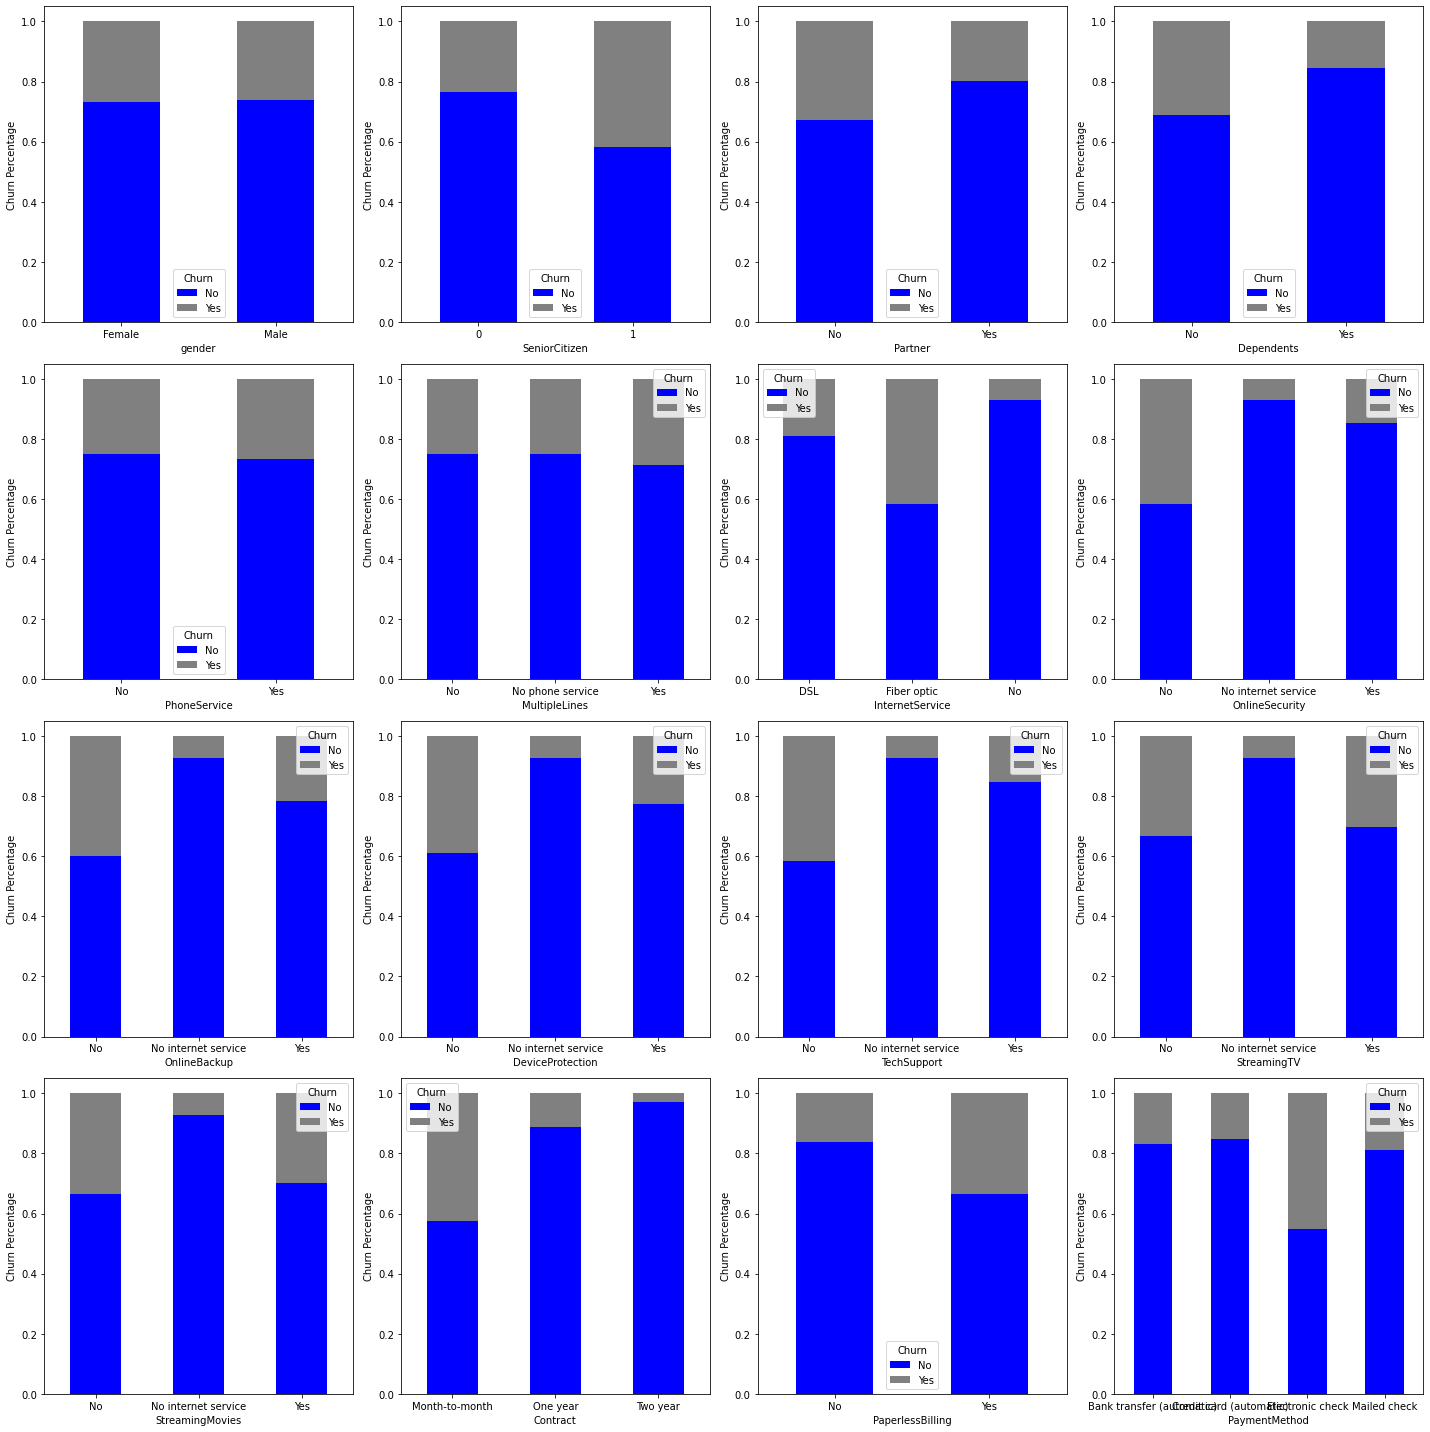

In [165]:
cols = 4
rows = 4

fig = plt.figure( figsize=(20, 20))
for i, predictor in enumerate(df.drop(columns=['Churn','tenure', 'MonthlyCharges','TotalCharges'])):
    ax=fig.add_subplot(rows,cols,i+1)
    stacked_plot(df, predictor, "Churn",ax)
    
fig.tight_layout()  
plt.show()     
    

## 3. Feature Engineering

**Divide customers into bins based on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...** 

In [166]:
# Get the max tenure
print(df['tenure'].max()) #72

72


In [167]:
# Group the tenure in bins of 12 months, and drop tenure
def tenure(t):
    if t<=12:
        return 1
    elif t>12 and t<=24:
        return 2
    elif t>24 and t<=36:
        return 3
    elif t>36 and t<=48:
        return 4
    elif t>48 and t<=60:
        return 5
    else:
        return 6

df["tenure_group"]=df["tenure"].apply(lambda x: tenure(x))
df.drop(columns= ['tenure'], axis=1, inplace=True)
df['tenure_group'].value_counts()

1    2153
6    1407
2    1024
3     832
5     832
4     762
Name: tenure_group, dtype: int64

<AxesSubplot:xlabel='tenure_group', ylabel='count'>

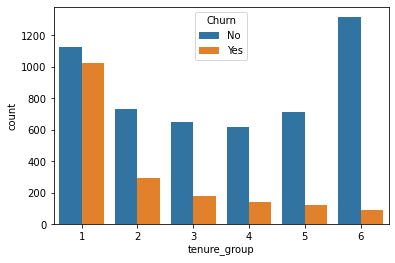

In [168]:
sns.countplot(x="tenure_group", hue="Churn", data=df)

In [169]:
# TotalCharges and MonthlyChar are highly correlated
df.drop('TotalCharges', axis = 1, inplace = True) 

**Normalize numerical columns of the datafram** 

In [170]:
cols_to_scale = ['tenure_group','MonthlyCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

**As we can see gender, multiplelines and phoneservice have similar churn rate. I will drop it**

In [171]:
df.drop(["gender", 'MultipleLines', 'PhoneService'], axis = 1, inplace = True)

**Convert Yes and No to 1 or 0**

In [172]:
yes_no_columns = ['Partner','Dependents','PaperlessBilling','Churn']
for col in yes_no_columns:
    df[col].replace({'Yes': 1,'No': 0},inplace=True)   

In [173]:
df

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,tenure_group
0,0,1,0,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,0.115423,0,0.0
1,0,0,0,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,0.385075,0,0.4
2,0,0,0,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,0.354229,1,0.0
3,0,0,0,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),0.239303,0,0.6
4,0,0,0,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,0.521891,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,1,Mailed check,0.662189,0,0.2
7039,0,1,1,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,1,Credit card (automatic),0.845274,0,1.0
7040,0,1,1,DSL,Yes,No,No,No,No,No,Month-to-month,1,Electronic check,0.112935,0,0.0
7041,1,1,0,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Mailed check,0.558706,1,0.0


**One hot encoding for Categorical columns**

In [174]:
# df = pd.get_dummies(data=df, columns=['tenure_group','InternetService','Contract','PaymentMethod'])

df = pd.get_dummies(data=df,  columns=['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], drop_first=True)
df.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling',
       'MonthlyCharges', 'Churn', 'tenure_group',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

### Feature Selection

**Correlation Analysis**

In [175]:
correlation = df.corr()
correlation

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,Churn,tenure_group,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
SeniorCitizen,1.000000,0.016030,-0.211479,0.155922,0.219131,0.151270,0.014935,0.254556,-0.181713,-0.181713,...,-0.061293,-0.181713,0.104830,-0.181713,0.119247,-0.047053,-0.116898,-0.024909,0.170949,-0.151840
Partner,0.016030,1.000000,0.451254,-0.014856,0.095277,-0.148670,0.367703,0.000212,0.002823,0.002823,...,0.118518,0.002823,0.122387,0.002823,0.115979,0.081661,0.246114,0.080889,-0.083856,-0.093854
Dependents,-0.211479,0.451254,1.000000,-0.110973,-0.114641,-0.162366,0.155587,-0.165140,0.141100,0.141100,...,0.061825,0.141100,-0.018146,0.141100,-0.040073,0.068243,0.200783,0.060125,-0.149862,0.059159
PaperlessBilling,0.155922,-0.014856,-0.110973,1.000000,0.350900,0.190518,0.002679,0.325295,-0.319082,-0.319082,...,0.037060,-0.319082,0.224151,-0.319082,0.211456,-0.052846,-0.147104,-0.014221,0.207569,-0.202521
MonthlyCharges,0.219131,0.095277,-0.114641,0.350900,1.000000,0.194008,0.239517,0.787169,-0.762181,-0.762181,...,0.337361,-0.762181,0.629336,-0.762181,0.626885,0.003271,-0.075152,0.028552,0.269931,-0.373324
Churn,0.151270,-0.148670,-0.162366,0.190518,0.194008,1.000000,-0.339636,0.307612,-0.228220,-0.228220,...,-0.163980,-0.228220,0.065058,-0.228220,0.062670,-0.177742,-0.301375,-0.134052,0.301079,-0.091649
tenure_group,0.014935,0.367703,0.155587,0.002679,0.239517,-0.339636,1.000000,0.018073,-0.034343,-0.034343,...,0.315459,-0.034343,0.271238,-0.034343,0.276139,0.204847,0.547571,0.226217,-0.205924,-0.223304
InternetService_Fiber optic,0.254556,0.000212,-0.165140,0.325295,0.787169,0.307612,0.018073,1.000000,-0.464418,-0.464418,...,-0.021020,-0.464418,0.329704,-0.464418,0.322398,-0.077498,-0.210967,-0.051204,0.334537,-0.304077
InternetService_No,-0.181713,0.002823,0.141100,-0.319082,-0.762181,-0.228220,-0.034343,-0.464418,1.000000,1.000000,...,-0.335128,1.000000,-0.414390,1.000000,-0.417891,0.039877,0.220282,0.003568,-0.282854,0.315183
OnlineSecurity_No internet service,-0.181713,0.002823,0.141100,-0.319082,-0.762181,-0.228220,-0.034343,-0.464418,1.000000,1.000000,...,-0.335128,1.000000,-0.414390,1.000000,-0.417891,0.039877,0.220282,0.003568,-0.282854,0.315183


<AxesSubplot:>

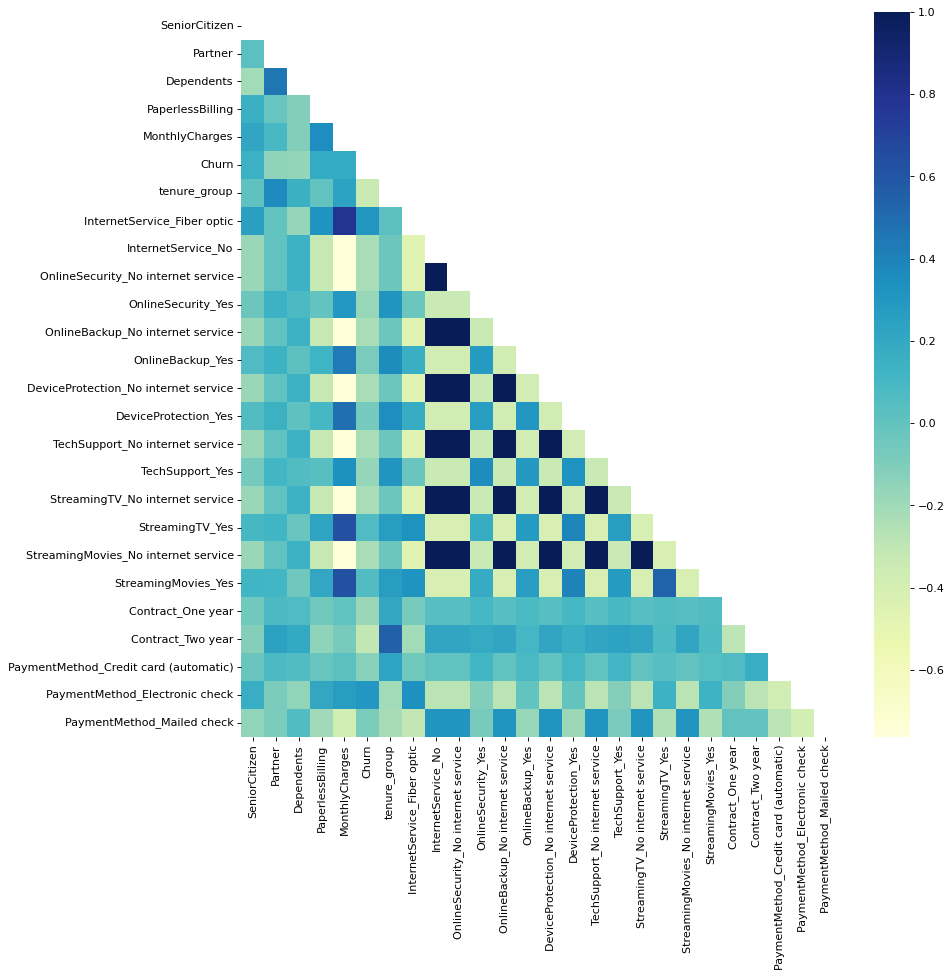

In [176]:
mask = np.triu(np.ones_like(df.corr()))
fig, ax = plt.subplots(figsize=(12,12),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), mask= mask, cmap="YlGnBu")

<AxesSubplot:>

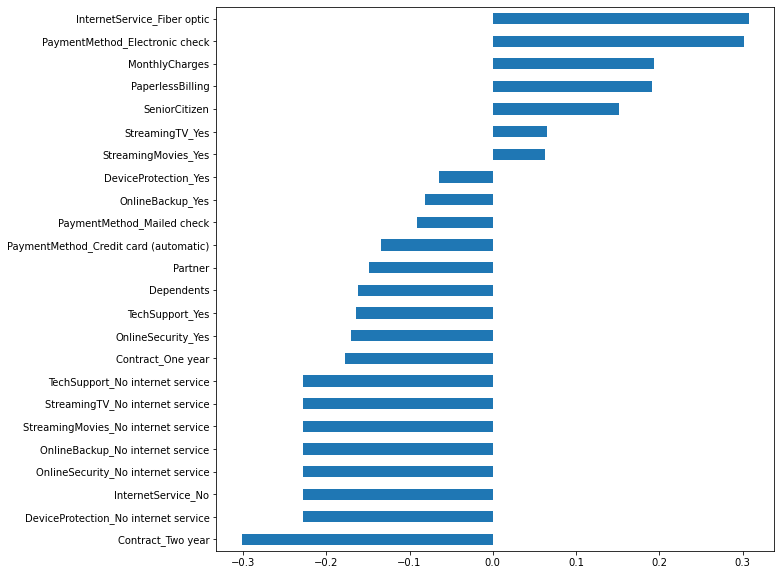

In [177]:
#Get Correlation of "Churn" with other variables:

plt.figure(figsize=(10,10))
df.corr()['Churn'].drop(['Churn','tenure_group']).sort_values(ascending = True).plot(kind='barh')

**Data Insight: **

**HIGH** Churn seen in case of  **Fibre Optics Internet**, **Electronic Check payment method**, **Month to month contracts**,, **Paperless billing**

**LOW** Churn is seens in case of  **Two year contracts**, and **No internet service** 

In [178]:
#find correlated Features
def correlation(X_train, threshold):
    col_corr=set()   #set all correlated col names
    corr_matrix=X_train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range (i):
            if abs(corr_matrix.iloc[i,j]) > threshold:  #we are interested in absoulute coeff value
                colname= corr_matrix.columns[i]   #get the name of col
                col_corr.add(colname)
    return col_corr       

threshold=0.9
correlation(df.iloc[:,:],threshold)

{'DeviceProtection_No internet service',
 'OnlineBackup_No internet service',
 'OnlineSecurity_No internet service',
 'StreamingMovies_No internet service',
 'StreamingTV_No internet service',
 'TechSupport_No internet service'}

In [179]:
#Remove  highly corelated Features.
df.drop(['DeviceProtection_No internet service',
 'OnlineBackup_No internet service',
 'OnlineSecurity_No internet service',
 'StreamingMovies_No internet service',
 'StreamingTV_No internet service',
 'TechSupport_No internet service'],axis=1,inplace= True)

**Save data**

In [180]:
df.to_csv('Tel_churn_output.csv',index=False)

## 4. Train test split

In [181]:
X = df.drop('Churn',axis='columns')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=5)

In [182]:
from sklearn.feature_selection import mutual_info_classif
mutual_info=mutual_info_classif(X_train,y_train)
mutual_data=pd.Series(mutual_info,index=X_train.columns)
mutual_data.sort_values(ascending=False)

tenure_group                             0.069113
Contract_Two year                        0.058905
InternetService_Fiber optic              0.056354
InternetService_No                       0.046483
PaymentMethod_Electronic check           0.044367
MonthlyCharges                           0.041374
PaymentMethod_Credit card (automatic)    0.018907
Partner                                  0.017441
PaperlessBilling                         0.015233
OnlineSecurity_Yes                       0.013302
StreamingTV_Yes                          0.012540
Contract_One year                        0.011901
SeniorCitizen                            0.009114
TechSupport_Yes                          0.007845
Dependents                               0.005371
DeviceProtection_Yes                     0.005157
StreamingMovies_Yes                      0.003865
OnlineBackup_Yes                         0.001985
PaymentMethod_Mailed check               0.000000
dtype: float64

**Define Fuctions For Model Evaluation Metrics**

In [183]:
def confusion_matrix_plot(X_train, y_train, X_test, y_test, classifier, y_pred, classifier_name):

    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(classifier, X_test, y_test, display_labels=['No Churn', 'churn'], 
                          cmap=plt.cm.Blues, normalize='true', ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix (norm.)')
    plt.show()
    
    print(f'Accuracy Score Test: {accuracy_score(y_test, y_pred)}')
    # print(f'Accuracy score Train: {classifier.score(X_train, y_train)}(as comparision)')
    return print("")

In [184]:
# function that plot ROC curve & AUC Score
def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
    
    y_pred_prob = y_pred_probabilities[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{classifier_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} ROC Curve')
    plt.show()
    
    return print(f'AUC Score (ROC): {roc_auc_score(y_test, y_pred_prob)}\n')
    

In [185]:
#  function for precision, recall- curve & f1 score
def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):

    y_pred_prob = y_pred_probabilities[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    
    plt.plot(recall, precision, label=f'{classifier_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} Precision-Recall Curve')
    plt.show()
    
    f1_score_result, auc_score_result = f1_score(y_test, y_pred), auc(recall, precision)
    
    return print(f'F1 score: {f1_score_result} \nAUC Score (PR): {auc_score_result}\n')

In [186]:
def print_score (y_test,y_pred):
    # print('confusion_matrix: ')
    # print(confusion_matrix(y_test,y_pred))
    print('\nclassification_report: ')
    print(classification_report(y_test,y_pred))
    print(f'accuracy score: {accuracy_score(y_test,y_pred)}')
    # print(f'roc auc score: {roc_auc_score(y_test,y_pred)}')
    # print(f'precision scor: {precision_score(y_test, y_pred)}')
    # print(f'recall score: {recall_score(y_test, y_pred)}')                         
    # print(f'f1_score: {f1_score(y_test, y_pred, average="weighted")}')

**Random Forest Classifier**

In [187]:
model_rf=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)
model_rf.fit(X_train,y_train)
y_pred=model_rf.predict(X_test)

print_score (y_test,y_pred)


classification_report: 
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1014
           1       0.70      0.39      0.50       388

    accuracy                           0.78      1402
   macro avg       0.75      0.66      0.68      1402
weighted avg       0.77      0.78      0.76      1402

accuracy score: 0.7845934379457917


**Applying PCA**

In [188]:
from sklearn.decomposition import PCA
pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

model_pca=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)
model_pca.fit(X_train_pca,y_train)
y_pred=model_pca.predict(X_test_pca)

print_score (y_test,y_pred)


classification_report: 
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1014
           1       0.65      0.38      0.48       388

    accuracy                           0.77      1402
   macro avg       0.72      0.65      0.67      1402
weighted avg       0.76      0.77      0.75      1402

accuracy score: 0.7717546362339515


There is no improvment With PCA

### Over sampling

Becasue Churn' Data is imbalanced, No/Yes ratio = 73:27, we tried over sampling, but not improvement. 

In [189]:
sm=SMOTETomek(0.7)
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

print("The num of classes before fit {}".format(Counter(y_train)))
print("the num of classes after fit {}".format(Counter(y_train_sm)))

The num of classes before fit Counter({0: 4139, 1: 1469})
the num of classes after fit Counter({0: 3818, 1: 2576})


## 5. Building Models

### Logistic Regression

In [190]:
#Fit the logistic Regression Model
logmodel = LogisticRegression(random_state=50)

grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2']}
cv=KFold(n_splits=10,random_state=None,shuffle=False)

logmodel=GridSearchCV(logmodel,grid,cv=cv,n_jobs=-1,scoring='recall')
logmodel.fit(X_train_sm,y_train_sm)
y_pred = logmodel.predict(X_test)
y_pred_prob = logmodel.predict_proba(X_test)

# Find Accuracy using accuracy_score method
logmodel_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

print_score (y_test,y_pred)


classification_report: 
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1014
           1       0.54      0.68      0.60       388

    accuracy                           0.75      1402
   macro avg       0.70      0.73      0.71      1402
weighted avg       0.77      0.75      0.76      1402

accuracy score: 0.7524964336661911


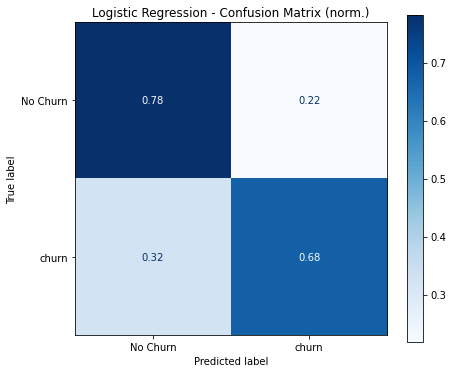

Accuracy Score Test: 0.7524964336661911



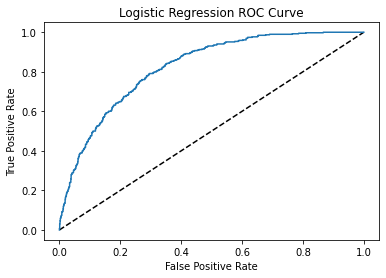

AUC Score (ROC): 0.823271874173936



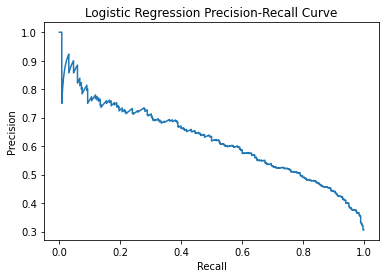

F1 score: 0.6025200458190149 
AUC Score (PR): 0.6202688100263847



In [191]:
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, logmodel, y_pred, "Logistic Regression")
roc_curve_auc_score(X_test, y_test, y_pred_prob,'Logistic Regression')
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_prob,'Logistic Regression')

### Random Forest

In [192]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20, 30],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [20,50,100, 200, 300]
}

rfmodel = RandomForestClassifier()

# Instantiate the grid search model
rfmodel = GridSearchCV(estimator = rfmodel, param_grid = param_grid, cv =10, n_jobs = -1, verbose = 1)
rfmodel.fit(X_train_sm,y_train_sm)
print(rfmodel.best_params_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
{'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}


In [193]:
y_pred=rfmodel.predict(X_test)
y_pred_prob = rfmodel.predict_proba(X_test)
rf_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

print_score (y_test,y_pred)


classification_report: 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1014
           1       0.58      0.61      0.59       388

    accuracy                           0.77      1402
   macro avg       0.71      0.72      0.72      1402
weighted avg       0.77      0.77      0.77      1402

accuracy score: 0.7710413694721826


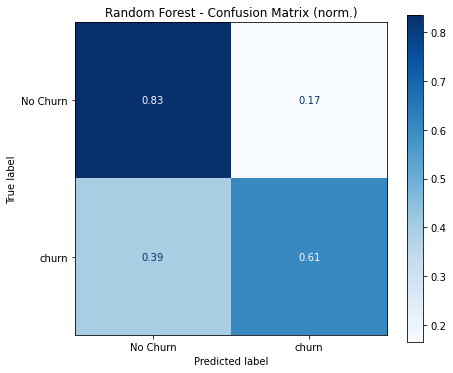

Accuracy Score Test: 0.7710413694721826



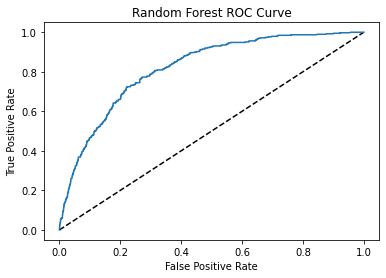

AUC Score (ROC): 0.8188251082779235



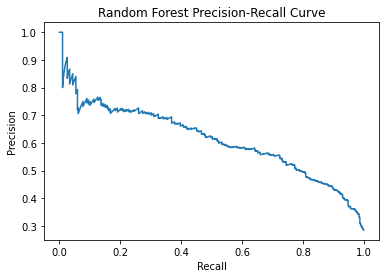

F1 score: 0.5941845764854614 
AUC Score (PR): 0.6124726356818839



In [194]:
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, rfmodel, y_pred, "Random Forest")
roc_curve_auc_score(X_test, y_test, y_pred_prob,"Random Forest")
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_prob,"Random Forest")

### Decision Tree

Fitting 10 folds for each of 72 candidates, totalling 720 fits


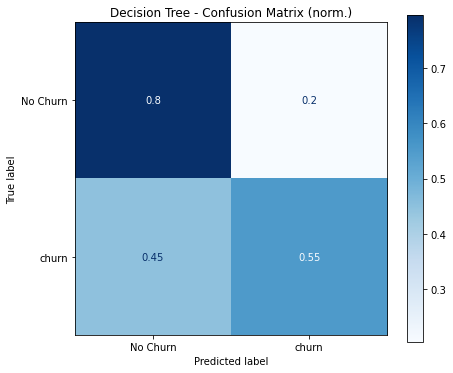

Accuracy Score Test: 0.7282453637660485


classification_report: 
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1014
           1       0.51      0.55      0.53       388

    accuracy                           0.73      1402
   macro avg       0.67      0.67      0.67      1402
weighted avg       0.74      0.73      0.73      1402

accuracy score: 0.7282453637660485


In [195]:
param_g = {
    'max_depth': [8, 15, 30, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}
    
dtmodel=DecisionTreeClassifier(criterion = "gini", random_state = 50)
dtmodel = GridSearchCV(estimator = dtmodel, param_grid = param_g, cv =10, n_jobs = -1, verbose = 2)
dtmodel.fit(X_train_sm, y_train_sm) 

#Predict the value for new, unseen data
y_pred = dtmodel.predict(X_test)

# Find Accuracy using accuracy_score method
dt_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, dtmodel, y_pred, "Decision Tree")
print_score (y_test,y_pred)

### SVM

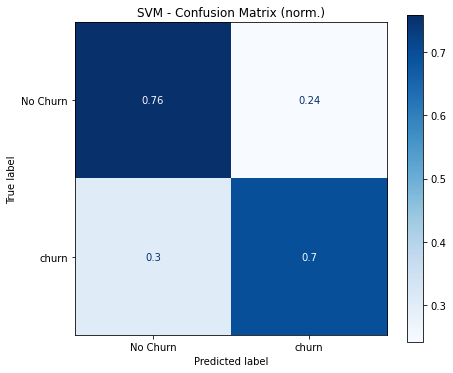

Accuracy Score Test: 0.7410841654778887


classification_report: 
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1014
           1       0.52      0.70      0.60       388

    accuracy                           0.74      1402
   macro avg       0.70      0.73      0.70      1402
weighted avg       0.77      0.74      0.75      1402

accuracy score: 0.7410841654778887


In [196]:
# defining parameter range 
# param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001] } #,'kernel': ['rbf','linear']}

svcmodel = SVC(kernel='linear',random_state=50, probability=True)
# svcmodel = GridSearchCV(svcmodel, param_grid, refit = True, verbose = 1) 
svcmodel.fit(X_train_sm,y_train_sm) 
y_pred=svcmodel.predict(X_test)

svc_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, svcmodel, y_pred, "SVM")
print_score (y_test,y_pred)

### K-Nearest Neighbor

In [197]:
#List Hyperparameters that we want to tune.
leaf_size = [1,2,3,4,8,16,32,64]
n_neighbors = [1,2,4,8,16,32]
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knnmodel = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knnmodel = GridSearchCV(knnmodel,hyperparameters, verbose = 1) 
knnmodel.fit(X_train_sm, y_train_sm) 
print(knnmodel.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}


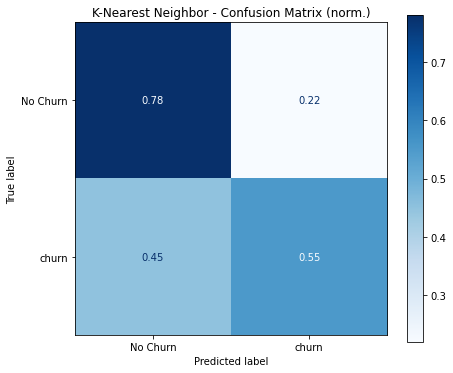

Accuracy Score Test: 0.7168330955777461


classification_report: 
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1014
           1       0.49      0.55      0.52       388

    accuracy                           0.72      1402
   macro avg       0.65      0.67      0.66      1402
weighted avg       0.73      0.72      0.72      1402

accuracy score: 0.7168330955777461


In [198]:
#Predict the value for new, unseen data
y_pred = knnmodel.predict(X_test)

# Find Accuracy using accuracy_score method
knn_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, knnmodel, y_pred, "K-Nearest Neighbor")
print_score (y_test,y_pred)

### Naive Bayes

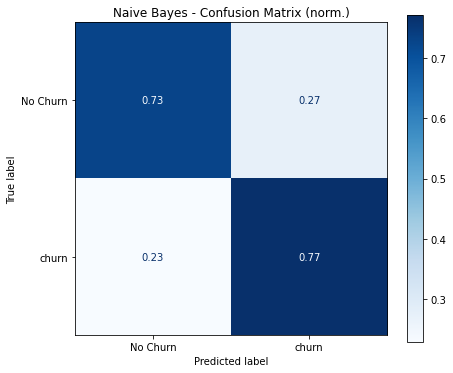

Accuracy Score Test: 0.738944365192582


classification_report: 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1014
           1       0.52      0.77      0.62       388

    accuracy                           0.74      1402
   macro avg       0.71      0.75      0.71      1402
weighted avg       0.79      0.74      0.75      1402

accuracy score: 0.738944365192582


In [199]:
gnb = GaussianNB() 
NB=gnb.fit(X_train_sm,y_train_sm)
y_pred=NB.predict(X_test)
nb_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, NB, y_pred, "Naive Bayes")
print_score (y_test,y_pred)

### Ridge Classifier

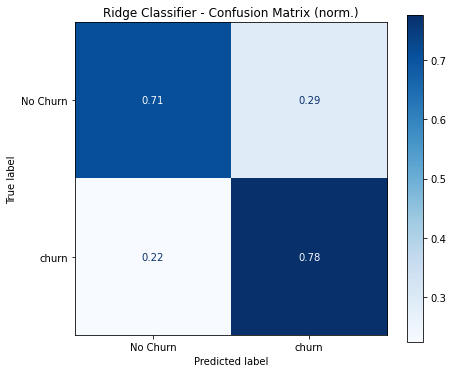

Accuracy Score Test: 0.7282453637660485


classification_report: 
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1014
           1       0.51      0.78      0.61       388

    accuracy                           0.73      1402
   macro avg       0.70      0.74      0.70      1402
weighted avg       0.79      0.73      0.74      1402

accuracy score: 0.7282453637660485


In [200]:
rc = RidgeClassifier(class_weight='balanced', random_state=42)
RC=rc.fit(X_train_sm,y_train_sm)
y_pred=RC.predict(X_test)
rc_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, RC, y_pred, "Ridge Classifier")
print_score (y_test,y_pred)

### Bagging Classifier

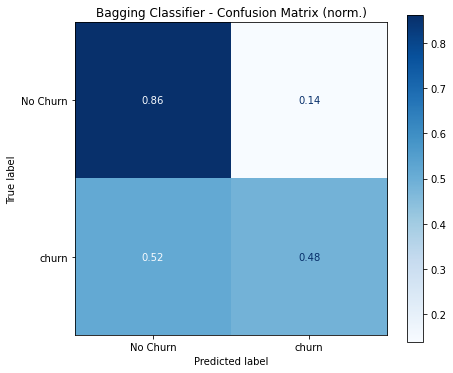

Accuracy Score Test: 0.7560627674750356


classification_report: 
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1014
           1       0.57      0.48      0.52       388

    accuracy                           0.76      1402
   macro avg       0.69      0.67      0.68      1402
weighted avg       0.75      0.76      0.75      1402

accuracy score: 0.7560627674750356


In [201]:
bgc = BaggingClassifier(random_state=124)
BGC=bgc.fit(X_train_sm,y_train_sm)
y_pred=BGC.predict(X_test)
bgc_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, BGC, y_pred, "Bagging Classifier")
print_score (y_test,y_pred)

### XGboost

In [202]:
#hyperparameter tuning
params={
    'learning_rate'   : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth'       : [3,4,5,6,8,10,12],
    'min_child_weight': [1,3,5,7],
    'gamma'           : [0.0, 0.1,0.2,0.3,0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}

Xgcls=xgboost.XGBClassifier(verbosity=0)
Xgcls=RandomizedSearchCV(Xgcls,param_distributions=params,scoring='accuracy',cv=10,verbose=0)
Xgcls.fit(X_train_sm,y_train_sm)
print(Xgcls.best_params_)

{'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.3}


In [203]:
y_pred = Xgcls.predict(X_test.values) #convert dataframe to array
y_pred_prob = Xgcls.predict_proba(X_test.values)
xgb_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print_score (y_test,y_pred)


classification_report: 
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1014
           1       0.57      0.57      0.57       388

    accuracy                           0.76      1402
   macro avg       0.71      0.71      0.71      1402
weighted avg       0.76      0.76      0.76      1402

accuracy score: 0.7646219686162625


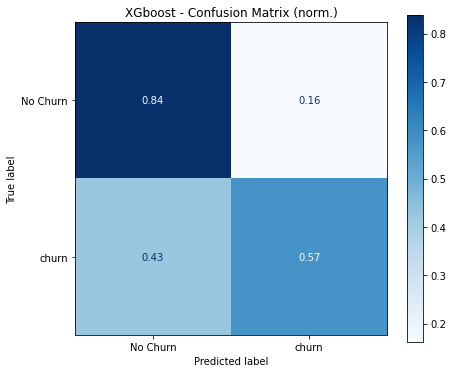

Accuracy Score Test: 0.7646219686162625



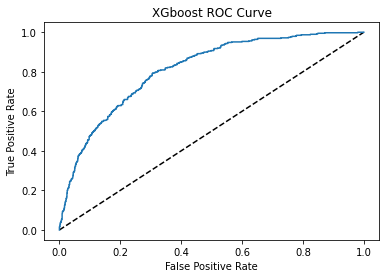

AUC Score (ROC): 0.8108999776327294



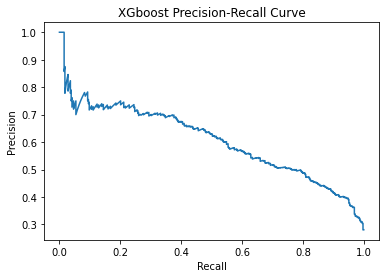

F1 score: 0.5747422680412371 
AUC Score (PR): 0.6052793952117407



In [204]:
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, Xgcls, y_pred, "XGboost")
roc_curve_auc_score(X_test, y_test, y_pred_prob,"XGboost")
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_prob,"XGboost")

### LightGBM

In [205]:
gbm = lightgbm.LGBMClassifier(objective='binary',
                        num_leaves=31,
                        metric = 'l2',
                        learning_rate=0.2,
                        n_estimators=5)
gbm.fit(X_train_sm, y_train_sm)

LGBMClassifier(learning_rate=0.2, metric='l2', n_estimators=5,
               objective='binary')

In [206]:
y_pred=gbm.predict(X_test)
y_pred_prob = gbm.predict_proba(X_test.values)
xgb_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print_score (y_test,y_pred)


classification_report: 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1014
           1       0.60      0.57      0.59       388

    accuracy                           0.78      1402
   macro avg       0.72      0.71      0.72      1402
weighted avg       0.77      0.78      0.77      1402

accuracy score: 0.7767475035663338


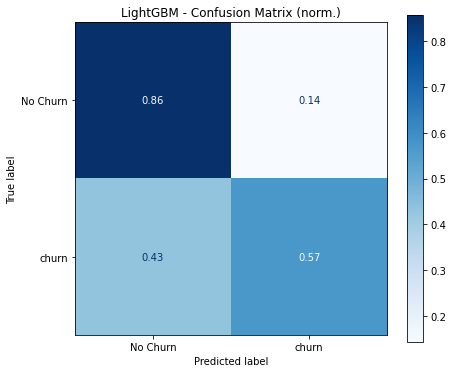

Accuracy Score Test: 0.7767475035663338



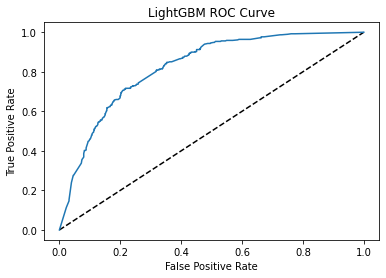

AUC Score (ROC): 0.8222945769535779



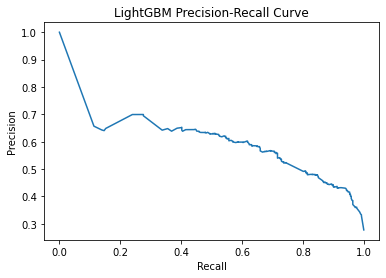

F1 score: 0.585430463576159 
AUC Score (PR): 0.6064435154915063



In [207]:
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, gbm, y_pred, "LightGBM")
roc_curve_auc_score(X_test, y_test, y_pred_prob,"LightGBM")
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_prob,"LightGBM")

### Multilayer Perceptron (Neural Network)

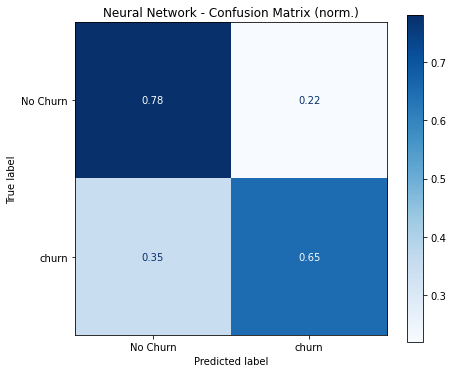

Accuracy Score Test: 0.7432239657631954


classification_report: 
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1014
           1       0.53      0.65      0.58       388

    accuracy                           0.74      1402
   macro avg       0.69      0.71      0.70      1402
weighted avg       0.76      0.74      0.75      1402

accuracy score: 0.7432239657631954


In [208]:
clf_mlp = MLPClassifier()
clf_mlp.fit(X_train_sm, y_train_sm)
y_pred=clf_mlp.predict(X_test)

mlp_accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, clf_mlp, y_pred, "Neural Network") 
print_score (y_test,y_pred)        

### Adaboost

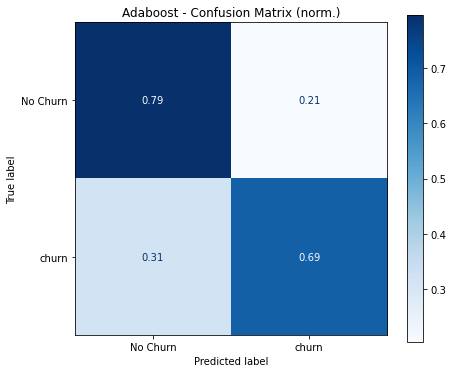

Accuracy Score Test: 0.7646219686162625


classification_report: 
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1014
           1       0.56      0.69      0.62       388

    accuracy                           0.76      1402
   macro avg       0.71      0.74      0.72      1402
weighted avg       0.78      0.76      0.77      1402

accuracy score: 0.7646219686162625


In [209]:
ad_S=AdaBoostClassifier()
ad_S.fit(X_train_sm,y_train_sm)
y_pred=ad_S.predict(X_test)
 
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, ad_S, y_pred, "Adaboost") 
print_score (y_test,y_pred)   

### Gradiant Boosting

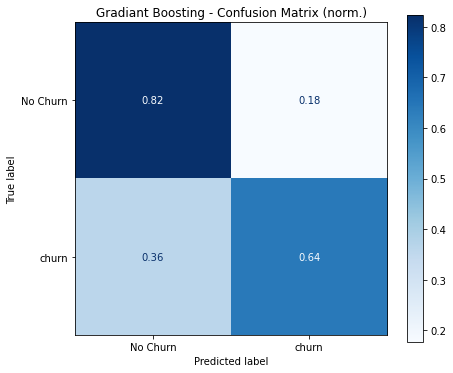

Accuracy Score Test: 0.7717546362339515


classification_report: 
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1014
           1       0.58      0.64      0.61       388

    accuracy                           0.77      1402
   macro avg       0.72      0.73      0.72      1402
weighted avg       0.78      0.77      0.78      1402

accuracy score: 0.7717546362339515


In [210]:
gbc_S=GradientBoostingClassifier()
gbc_S.fit(X_train_sm,y_train_sm)

y_pred=gbc_S.predict(X_test)
 
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, gbc_S, y_pred, "Gradiant Boosting") 
print_score (y_test,y_pred) 

### CatBoost

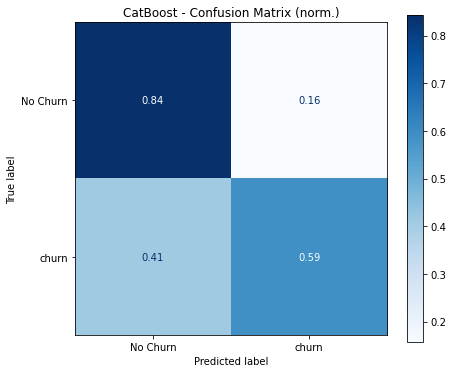

Accuracy Score Test: 0.7724679029957204


classification_report: 
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1014
           1       0.59      0.59      0.59       388

    accuracy                           0.77      1402
   macro avg       0.72      0.72      0.72      1402
weighted avg       0.77      0.77      0.77      1402

accuracy score: 0.7724679029957204


In [211]:
cbt_S=CatBoostClassifier(verbose=False)
cbt_S.fit(X_train_sm,y_train_sm)

y_pred=cbt_S.predict(X_test)
 
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, cbt_S, y_pred, "CatBoost") 
print_score (y_test,y_pred)

### Compare Several models according to their Accuracies

In [212]:

Model_Comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbor', 
              'Decision Tree', 'Random Forest','Naive Bayes','Ridge Classifier',
              'Bagging Classifier','XGboost','LightGBM','Neural Network'],
    'Score': [logmodel_accuracy, svc_accuracy, knn_accuracy, 
              dt_accuracy, rf_accuracy, nb_accuracy, rc_accuracy,
              bgc_accuracy, xgb_accuracy,xgb_accuracy,mlp_accuracy]})
Model_Comparison_df = Model_Comparison.sort_values(by='Score', ascending=False)
Model_Comparison_df = Model_Comparison_df.set_index('Score')
Model_Comparison_df.reset_index()

,Score,Model
0,77.67,XGboost
1,77.67,LightGBM
2,77.10,Random Forest
3,75.61,Bagging Classifier
4,75.25,Logistic Regression
5,74.32,Neural Network
6,74.11,Support Vector Machine
7,73.89,Naive Bayes
8,72.82,Decision Tree
9,72.82,Ridge Classifier


### Voting Classifier

In [213]:
from sklearn.ensemble import VotingClassifier 
from sklearn.model_selection import cross_val_score

recal=make_scorer(recall_score)

In [214]:
clf1= AdaBoostClassifier()
clf2= LogisticRegression()
clf3= MLPClassifier(verbose=0)
clf4= RandomForestClassifier()

print('5-fold cross validation:/n')
labels = ['AdaBoost','Logistic Regression','MLP','random Forest']

for clf, label in zip([clf1,clf2,clf3,clf4],labels):
    scores =cross_val_score(clf,X_train_sm,y_train_sm,cv=10,scoring='recall')
    
    print("Accuracy: %0.2f (+/- %0.2f)[%s]"
         %(scores.mean(),scores.std(), label))

5-fold cross validation:/n
Accuracy: 0.79 (+/- 0.04)[AdaBoost]
Accuracy: 0.78 (+/- 0.03)[Logistic Regression]
Accuracy: 0.77 (+/- 0.05)[MLP]
Accuracy: 0.81 (+/- 0.07)[random Forest]


In [215]:
voting_clf_soft =  VotingClassifier(estimators = [(labels[0], clf1),(labels[1], clf2),
                                       (labels[2], clf3),(labels[3], clf4)], 
                                       voting = 'soft')
voting_clf_soft.fit(X_train_sm, y_train_sm)

VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()),
                             ('Logistic Regression', LogisticRegression()),
                             ('MLP', MLPClassifier(verbose=0)),
                             ('random Forest', RandomForestClassifier())],
                 voting='soft')

In [216]:
y_pred=voting_clf_soft.predict(X_test)
y_pred_prob = voting_clf_soft.predict_proba(X_test)

print_score (y_test,y_pred)


classification_report: 
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1014
           1       0.58      0.64      0.60       388

    accuracy                           0.77      1402
   macro avg       0.72      0.73      0.72      1402
weighted avg       0.78      0.77      0.77      1402

accuracy score: 0.7696148359486448


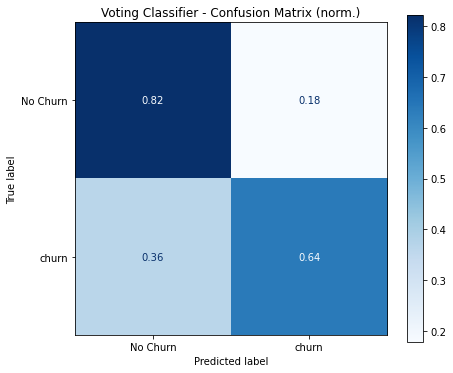

Accuracy Score Test: 0.7696148359486448



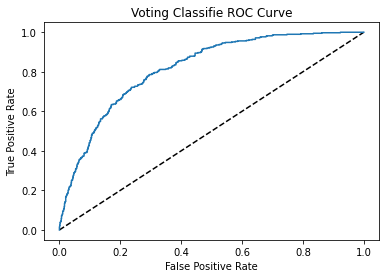

AUC Score (ROC): 0.8173597978812094



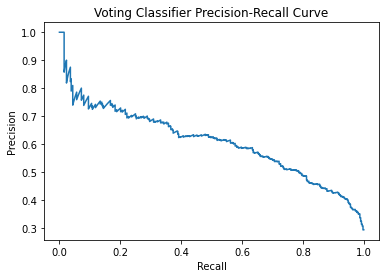

F1 score: 0.6046511627906977 
AUC Score (PR): 0.608152230578541



In [217]:
confusion_matrix_plot(X_train_sm, y_train_sm, X_test, y_test, voting_clf_soft, y_pred, "Voting Classifier")
roc_curve_auc_score(X_test, y_test, y_pred_prob,'Voting Classifie')
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_prob,'Voting Classifier')

### Build a Deep Learning model (ANN) in tensorflow/keras

In [218]:
Model_dim = X.shape[1]

model = keras.Sequential([
    keras.layers.Dense(Model_dim, input_shape=(Model_dim,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_sm, y_train_sm, epochs=50, #100
                   validation_data=(X_test, y_test),
                   verbose =0)

In [219]:
model.evaluate(X_test, y_test)
yp = model.predict(X_test)

y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(classification_report(y_test,y_pred))        

44/44 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1014
           1       0.55      0.61      0.58       388

    accuracy                           0.75      1402
   macro avg       0.70      0.71      0.70      1402
weighted avg       0.76      0.75      0.76      1402



Text(69.0, 0.5, 'True Lable')

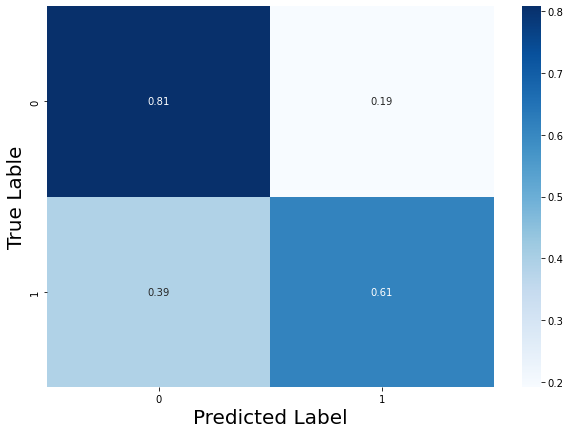

In [220]:
import seaborn as sn
cm = confusion_matrix(y_test,y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True,cmap=plt.cm.Blues) #, fmt='d')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Lable', fontsize=20)

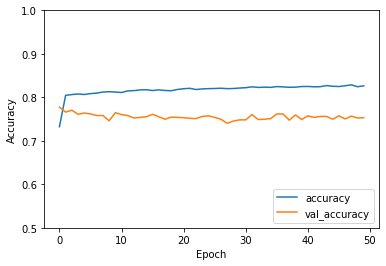

In [221]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Save Model and partial dependence plot

In [222]:
# Save Random Forest Model
pickle.dump(rfmodel, open('model.pkl','wb'))

In [223]:
import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots

In [224]:
perm = PermutationImportance(rfmodel, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top = 19)

Weight,Feature
0.0335 ± 0.0145,tenure_group
0.0088 ± 0.0068,InternetService_No
0.0078 ± 0.0123,Contract_Two year
0.0074 ± 0.0104,OnlineSecurity_Yes
0.0064 ± 0.0077,Contract_One year
0.0058 ± 0.0054,InternetService_Fiber optic
0.0040 ± 0.0048,PaymentMethod_Credit card (automatic)
0.0030 ± 0.0074,MonthlyCharges
0.0029 ± 0.0090,PaperlessBilling
0.0017 ± 0.0031,StreamingTV_Yes
